# Cell-type Classification on BMNC CITE Seq Data

The CITE-Seq data set consists of two modalities: RNA (Gene Expression) and Protein (Antibody Derived Tags \[ADTs\])

Here, we have also predicted ADT data from XGBoost and cTPnet, based on the measured gene expression.

In this notebook, cell-type classification will be done with the following as input data:
1. Measured gene expression only
2. Measured gene expression and ADT
3. Measured gene expression and XGBoost predicted ADT
4. Measured gene expression and cTPnet predicted ADT

(1) is the control.  
(2) uses a multi-omic approach to determine if the ADT data adds anything of value to the classification task.  
(3) and (4) are used to infer whether the ADT data can be predicted from the gene expression itself, in which case measuring ADTs would become unnecessary. Also, (3) and (4) can be compared to determine which method is better for prediciting ADT values.

In [1]:
# Loading necessary libraries and functions
import sys
sys.path.append('../')
from main import train_model
from experimental import process, train
import pandas as pd
import numpy as np

# File locations
rna_file = "../../CITEseq_BMNC/rna.csv"
adt_file = "../R/CITE_Seq_BMNC/adt.csv"
adt_xgboost_file = "../R/CITE_Seq_BMNC/adt_xgboost.csv"
adt_ctpnet_file = "../R/CITE_Seq_BMNC/adt_ctpnet.csv"
meta_file = "../R/CITE_Seq_BMNC/cell_type.csv"
trte_partition_file = "../R/CITE_Seq_BMNC/trte_partition.txt"

## Measured Gene Expression Only

In [44]:
# Setting all variables for run
# SEED can be "random" or integer, if integer, it will be used as the seed for random, numpy, torch, and cuda
SEED = 42 

# change label from text to integer
#labels = pd.read_csv(meta_file, index_col="cell_id")
#label_dict = dict(zip(set(labels["cell_type"]), range(len(set(labels["cell_type"])))))

COMBINER = False 
doSMOTE = False 

# Training parameters
num_epoch = 2000
test_interval = 50
lr = 5e-2
weight_decay = 1e-4
dropout = 0.2
adj_parameter = 10 # average number of edge per node in adj matrix

VERBOSE = 1 #0, only print final result; 1, only testing result; 2, training and testing result
OUTPUT_FILES = False #Boolean to determine whether to output loss and metrics as csv files
MAKE_PLOTS = False #Boolean to determine whether to output loss and metrics as plots in png format
REPEATS = 1 #Integer, how many times to independently train the model
feature_extract = []

In [34]:
RUN_TITLE = "BMNC CITE-Seq RNA Only"
RUN_TITLE_SHORT = "RNA Only"

load_list = [rna_file, meta_file, trte_partition_file]
GCN_names = ["RNA"]

rna = pd.read_csv(adt_file, index_col="cell_id")
meta = pd.read_csv(meta_file, index_col="cell_id")

In [35]:
# Getting labels
#meta = pd.read_csv(meta_file, index_col="cell_id")
#meta = meta.reindex(index=mirna.index)
#labels.iloc[:].value_counts()
label_dict = dict(zip(set(meta["cell_type"]), range(len(set(meta["cell_type"])))))
#labels = [label_dict[x] for x in meta_smol.iloc[:].tolist()]


# Getting training and testing indices
patient_id = rna.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

rna_train = rna.iloc[tr_idx,:]
rna_test = rna.iloc[te_idx,:]

meta_train = meta.iloc[tr_idx,:]
meta_test = meta.iloc[te_idx,:]

In [36]:
# A mixture of oversampling and undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Setting the target so that the data is undersampled so that every cell_type that has more than 200 samples is reduced to 200
target = meta_train["cell_type"].value_counts().to_dict()
for key in target:
    target[key] = min(target[key],200)

under = RandomUnderSampler(random_state=SEED, sampling_strategy=target)
rna_smol, meta_smol = under.fit_resample(rna_train, meta_train["cell_type"])

# Setting the target so that cell_types with fewer than 200 samples are oversampled to 200
for key in target:
    target[key] = 200
smote = SMOTE(random_state=SEED, sampling_strategy=target)

rna_smol, meta_smol = smote.fit_resample(rna_smol, meta_smol)

In [37]:
tr_idx = list(range(meta_smol.shape[0]))
te_idx = list(range(meta_smol.shape[0], meta_smol.shape[0] + meta_test.shape[0]))

meta_sampled = pd.concat([meta_smol, meta_test["cell_type"]])

label_dict = dict(zip(set(meta["cell_type"]), range(len(set(meta["cell_type"])))))
labels = [label_dict[x] for x in meta_sampled.iloc[:].tolist()]

# Combine rna_smol and rna_test
rna_sampled = pd.concat([rna_smol, rna_test])

In [38]:
meta_sampled

0                        CD14 Mono
1                        CD14 Mono
2                        CD14 Mono
3                        CD14 Mono
4                        CD14 Mono
                           ...    
b_TGTATTCGTCGAGATG-1       Naive B
a_CTCCTAGTCCCTCAGT-1      Prog_RBC
b_CCACCTATCACAACGT-1     CD14 Mono
b_ACGGGTCCAGGAATCG-1     CD4 Naive
a_ACACTGAAGGCCCTTG-1    CD4 Memory
Name: cell_type, Length: 11535, dtype: object

In [39]:
rna_sampled

,CD11a,CD11c,CD123,CD127-IL7Ra,CD14,CD16,CD161,CD19,CD197-CCR7,CD25,...,CD38,CD4,CD45RA,CD45RO,CD56,CD57,CD69,CD79b,CD8a,HLA.DR
0,1.008456,1.326820,0.477189,-1.081193,2.267976,-0.373378,0.011146,-0.224785,-0.923808,-0.256781,...,0.557612,-0.096846,-0.418549,-0.802722,0.661886,-0.550688,1.813532,-0.702923,-0.347983,0.817615
1,1.236984,1.749648,-0.240313,-0.905275,2.462759,-0.189878,-0.537631,-0.177359,-0.566352,0.112640,...,1.088275,-0.112450,-0.654733,-0.581898,-0.022944,-0.708194,0.095634,-0.495930,-0.481349,1.532962
2,0.664105,1.496739,0.980885,-0.797813,1.423503,-0.584164,-0.531169,-0.068694,5.304331,-0.497670,...,0.923182,-0.263173,-0.523906,-0.102443,-0.171033,-0.793021,-0.489412,-0.254560,-0.432594,0.749114
3,1.115978,2.462627,0.088708,-0.884168,1.787883,-0.395212,-0.853929,-0.326391,0.006930,0.660554,...,0.032067,0.240550,-1.042633,1.787389,-0.395448,-0.020022,1.537425,-0.418384,-0.491857,1.393109
4,0.460720,1.706076,-0.487815,-0.764993,2.407533,-0.406633,-0.355663,-0.533175,-0.537303,-0.714804,...,0.005299,0.187539,-0.986964,1.195195,-0.153619,-0.583778,0.314640,1.071545,-0.542955,0.713715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_TGTATTCGTCGAGATG-1,-1.054774,-0.539168,-0.294171,-0.683021,-0.541193,-0.314337,-0.807297,3.224252,4.798550,0.126461,...,-0.308001,-1.111132,1.511418,-0.531798,-0.186233,-0.522371,0.516938,2.571959,-0.235952,1.955505
a_CTCCTAGTCCCTCAGT-1,-1.310323,0.130592,-0.163556,-0.525679,-0.334919,0.686499,-0.206126,0.272209,1.353556,-0.319970,...,-0.387100,-0.254037,-0.475522,-0.345480,-0.742176,-0.356886,-0.352180,-0.848767,-0.446390,-0.776490
b_CCACCTATCACAACGT-1,0.810897,1.171183,-0.435600,-0.949620,1.777665,-0.284265,-0.276903,-0.036407,-0.588652,0.801612,...,0.397138,-0.251959,-0.613182,0.635697,-0.501043,0.196963,-0.049359,1.055265,-0.317893,0.418941
b_ACGGGTCCAGGAATCG-1,-0.651924,-0.765139,-0.365617,0.514959,-0.491961,-0.325526,-0.332831,-0.312706,0.386375,-0.508181,...,0.080153,1.690936,-0.416793,-0.165038,-0.179225,-0.896735,-0.603153,-0.155163,-0.808197,-1.004661


In [40]:
data_list = [rna_sampled]
labels = np.array(labels)
indices = (tr_idx, te_idx)

GCN_names = ["RNA"]
COMBINER = False

data = process(data_list, labels, indices, SEED=SEED)

SEED =  42


In [45]:
loss_rna, metrics_rna, _, _ = train(data, label_dict=label_dict, GCN_names=GCN_names, COMBINER=COMBINER,
        SEED=SEED, num_epoch=num_epoch, test_interval=test_interval, lr=lr, weight_decay=weight_decay, 
        dropout=dropout, adj_parameter=adj_parameter, VERBOSE=VERBOSE,
        RUN_TITLE=RUN_TITLE, RUN_TITLE_SHORT=RUN_TITLE_SHORT,
        OUTPUT_FILES=OUTPUT_FILES, feature_extract=feature_extract)

#losses_tcga.to_csv("loss_rna.csv")
#metrics_tcga.to_csv("metric_rna.csv")

2021-07-14 23:17:24.709532 

BMNC CITE-Seq RNA Only
SEED =  42

Training...

Test: Epoch 0
Train Accuracy: 0.0350   Test ACC: 0.0104
Train F1: 0.0118         Test F1: 0.0002

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0500              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0150              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              1.0000
CD8 Memory_2 	           0.0370        


Test: Epoch 200
Train Accuracy: 0.0370   Test ACC: 0.0145
Train F1: 0.0026         Test F1: 0.0004

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	       


Test: Epoch 400
Train Accuracy: 0.0370   Test ACC: 0.0448
Train F1: 0.0026         Test F1: 0.0038

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	       


Test: Epoch 600
Train Accuracy: 0.0370   Test ACC: 0.0057
Train F1: 0.0026         Test F1: 0.0001

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              1.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	       


Test: Epoch 800
Train Accuracy: 0.0370   Test ACC: 0.0095
Train F1: 0.0026         Test F1: 0.0002

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	       


Test: Epoch 1000
Train Accuracy: 0.0370   Test ACC: 0.2148
Train F1: 0.0026         Test F1: 0.0760

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      


Test: Epoch 1200
Train Accuracy: 0.0370   Test ACC: 0.0145
Train F1: 0.0026         Test F1: 0.0004

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      


Test: Epoch 1400
Train Accuracy: 0.0370   Test ACC: 0.0145
Train F1: 0.0026         Test F1: 0.0004

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      


Test: Epoch 1600
Train Accuracy: 0.0370   Test ACC: 0.0145
Train F1: 0.0026         Test F1: 0.0004

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      


Test: Epoch 1800
Train Accuracy: 0.0370   Test ACC: 0.0057
Train F1: 0.0026         Test F1: 0.0001

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      


Test: Epoch 2000
Train Accuracy: 0.0370   Test ACC: 0.0145
Train F1: 0.0026         Test F1: 0.0004

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD8 Naive 	           0.0370              0.0000              0.1276              0.0000
Naive B 	           0.0370              0.0000              0.0650              0.0000
gdT 	           0.0370              0.0000              0.0135              0.0000
cDC2 	           0.0370              0.0000              0.0181              0.0000
CD56 bright NK 	           0.0370              0.0000              0.0041              0.0000
LMPP 	           0.0370              0.0000              0.0086              0.0000
pDC 	           0.0370              0.0000              0.0104              0.0000
CD8 Memory_2 	           0.0370              0.0000              0.0189              0.0000
CD8 Memory_1 	      

<AxesSubplot:>

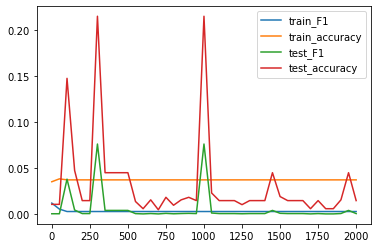

In [46]:
metrics_rna.plot(y = ["train_F1", "train_accuracy", "test_F1", "test_accuracy"])

<AxesSubplot:>

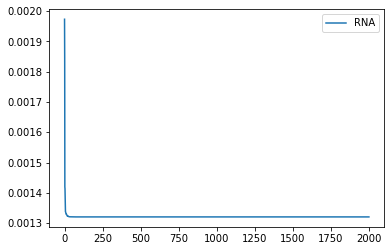

In [47]:
loss_rna.plot()